<font size = 12>Counting photons: an example </font>

Authors: Leonardo Assis Morais

Example notebook on how to load your raw data from the FPGA and obtain <br>
photon-number-resolving measurements.

You will need to create your own notebook to analyse your data, but <br>
this notebook should serve as a reference.

#TODO: add a .csv calibration file to the package for testing this notebook

# Getting the data

You will need to have the data on your computer for this notebook <br>
to work properly.

In order to get the data, you will need to use a ftp protocol.

In Mac, I can press CMD + K and type the following address: <br>
ftp://smp-qtlab11.instrument.net.uq.edu.au

This will grant you access to the folder ’captures’ where all <br>
measurements made with the FPGA are stored. <br>

Copy the folder with your data set to your machine in a <br>
folder that you know. <br>

You will need to know this address to run the notebook below.

In [11]:
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload

# Loading Data

In this example, we do not load the characteristics of channel 1 <br> 
because they are just the heralding channel. 

In [38]:
from tes.data import CaptureData

# edit the path below with the folder where the data is stored in 
# your machine
DATAPATH = ('/Users/leo/TES_package_and_data/TES3_80mK_820nm_10khz_'
            '50ns_2_6V_1MBW_peak2_h078df2b2/drive-pulse_BL-pulse_'
            'threshold-slope_max')

data = CaptureData(DATAPATH)
# boolean mask for events in channel 0
# in this example, these are photon detections
ch0 = data.mask(0)
# boolean mask for events in channel 1
# in this example, this is the heralding signal
ch1 = data.mask(1)

# times register the timestamp for both channels
times = data.time # relative time from last event

# pulse height (or maximum slope) for ch0
heights = data.rise[ch0]['height'][:,0]
# pulse area for ch0
areas = data.area[ch0]
# pulse length for ch0
lengths = data.pulse_length[ch0]

# other characteristics
# pulse minima for ch0
minima = data.rise[ch0]['minimum'][:,0]
# pulse rise time for ch0
rise_time = data.rise[ch0]['rise_time'][:,0]

# Loading Thresholds

To obtain the thresholds, use the notebook TES Calibration.ipynb, <br>
which is also available under the TES package.

In [7]:
from tes.traces import get_thresholds

# edit with the calibration file address
CALIBRATION_FILE = '/Users/leo/Desktop/calibration.csv'
threshold_list = get_thresholds(CALIBRATION_FILE)

Data used for calibration: 
 /Users/leo/TES_package_and_data/TES3_80mK_820nm_10khz_50ns_2_6V_1MBW_peak1_h078df2b2/drive-pulse_BL-pulse_threshold-slope_max


# Coincidence Detections

times as read from CaptureData(DATAPATH) is a vector in which each entry <br>
is the time relative to the last event. <br>
Using np.cumsum to calculate the cumulative sum, we construct the <br>
abs_time vector where each entry is the time elapsed since the <br>
beginning of the measurements.

In the cell below, you will also: <br>
- choose the herald list mask;
- choose the time intervals for the coincidence window (in nanoseconds)
- choose where to save the file with the coincidence counts

In [12]:
# timestamp for the first photon-detection event
initial_time = times[0]
abs_time = np.cumsum(times,dtype=np.uint64) - initial_time

# for this example data set, ch1 is the heralding channel
herald_list = ch1

# coincidence window in nanoseconds
low_end = 100 
high_end = 700

# folder where you will save coincidence data
folder_coinc = '/Users/leo/Desktop'

Below, we define the coincidence mask (coinc_mask), which registers <br>
the ocurrence of a coincidence detection - and coincidence <br>
vector (coinc) - saves the indices where the coincidences <br>
ocurred - for the detectors and save it on a file.

In [18]:
fname = Path(f'{folder_coinc}/_coinc_{int(low_time):d}_{int(high_time):d}')
# define the coincidence window
low_time = np.floor(low_end/4)
high_time = np.ceil(high_end/4)
# determining the coincidence mask to find vacuum counts
# check if a coincidence masks already exists
# and create one if it does not
if (fname).with_suffix('.npz').exists():
    data = np.load((fname).with_suffix('.npz'))
    coinc = data['coinc']
    coinc_mask = data['coinc_mask']
    low_time = data['low']
    high_time = data['high']
else:
    coinc, coinc_mask = coincidence(abs_time, herald_list, low_time, high_time)
    np.savez(
        (fname),
        coinc=coinc, coinc_mask=coinc_mask, low=low_time, high=high_time
    )

In [22]:
photon_counts = counting_photons(data = areas,
                                 thresh_list = threshold_list,
                                 vacuum = True,
                                 coinc_mask = coinc_mask,
                                 herald_mask = ch1
                                 )

388
The number of uncorrelated counts is [1042039     388       1       0       2       1       0       0       0
       0       4]
The total number of counts is [0, 2970488, 4228675, 4015581, 2860254, 1630851, 775593, 314707, 112810, 35928, 13617]
The number of counts minus the uncorrelated counts is [-1042039  2970100  4228674  4015581  2860252  1630850   775593   314707
   112810    35928    13613]


# Saving the counts in a .csv file

Remember to change the file name.

In [ ]:
FILENAME = '/Users/leo/Desktop/counts_testing.csv'

In [30]:
with open(FILENAME, mode='w') as count_file: 
    fock_numbers = [i for i in range(0, len(threshold_list)+1)]
    writer = csv.writer(count_file)
    writer.writerow([str(datapath)])
    writer.writerow(["Correlated Counts \n"])
    writer.writerow(fock_numbers)
    writer.writerow(photon_counts[0])
    writer.writerow(["Uncorrelated Counts \n"])
    writer.writerow(fock_numbers)
    writer.writerow(photon_counts[1])

# Reading data

To test the previous section, we read the data saved on the .csv file <br>
and plot it below.

Remember to check the file path when running this cell.

In [31]:
FILEPATH = '/Users/leo/Desktop/counts_testing.csv'

In [37]:
data_list = []
read_correlated = []
read_uncorrelated = []

# reading data from file
with open(FILEPATH, mode='r') as count_file:
    csv_reader = csv.reader(count_file, delimiter=',')
    header = next(csv_reader)
    data_list.append(header)
    idx = 0
    if header != None:
        for row in csv_reader:
            if idx%7 == 2:
                read_correlated.append(row)
            if idx%7 == 5:
                read_uncorrelated.append(row)
            idx += 1

# creating the variables to store the information appropriately
correlated = []
uncorrelated = []

for count, element in enumerate(read_correlated):
    correlated.append(np.array([int(idx) for 
                                idx in read_correlated[count]])
                     )
    uncorrelated.append(np.array([int(idx) for 
                                idx in read_uncorrelated[count]])
                       )

# inverting list so it is ordered from the lowest to highest intensity
correlated = np.flip(correlated, axis=0)
uncorrelated = np.flip(uncorrelated, axis=0);

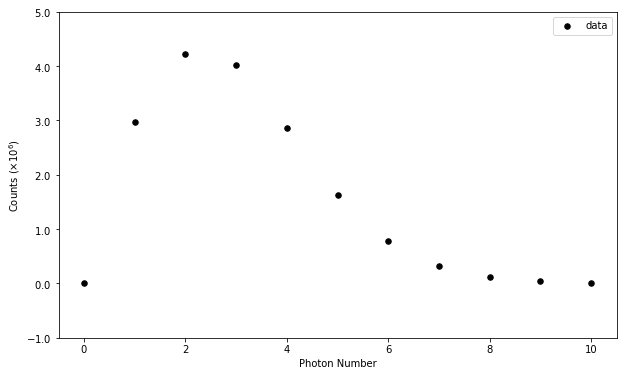

In [36]:
%matplotlib inline
from tes.traces import correct_xticks, correct_yticks

fig, ax = plt.subplots(figsize=([10,6]))

fock = [i for i in range(0, len(threshold_list)+1)]

# plotting
ax.scatter(fock, correlated, color='black', label='data', s=30)

expy = correct_yticks(ax)
ax.set_xlabel(r'Photon Number')
ax.set_ylabel(r'Counts ($\times 10^{}$)'.format(expy))

ax.legend()

<font size = 12>END OF NOTEBOOK </font>